In [20]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

In [21]:
# Load the data
# Lung cancer data
df = pd.read_csv("lung.csv")
df.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [22]:
df["status"] = df["status"].replace({1:0, 2:1})
df.sort_values("time").head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
56,5.0,5,1,65,2,0.0,100.0,80.0,338.0,5.0
107,1.0,11,1,67,1,1.0,90.0,90.0,925.0,NaN
72,5.0,11,1,74,1,2.0,70.0,100.0,1175.0,0.0
78,3.0,11,1,81,1,0.0,90.0,NaN,731.0,15.0
29,1.0,12,1,74,1,2.0,70.0,50.0,305.0,20.0


# Kaplan Meier Estimator

The Kaplan-Meier Estimator is a method used to estimate the chance of an event (like survival) happening over time, based on observed data.

In [23]:
model = KaplanMeierFitter()
model.fit(durations=df["time"], event_observed=df["status"])

model.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223


In [24]:
model.event_table.tail()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3
1010.0,1,0,1,0,2
1022.0,1,0,1,0,1


In [25]:
# Calculate the survival probability at specific times
specific_times = [30, 90, 180, 360, 720, 1080]
model.predict(specific_times)

30      0.956140
90      0.881579
180     0.721671
360     0.434044
720     0.124593
1080    0.050346
Name: KM_estimate, dtype: float64

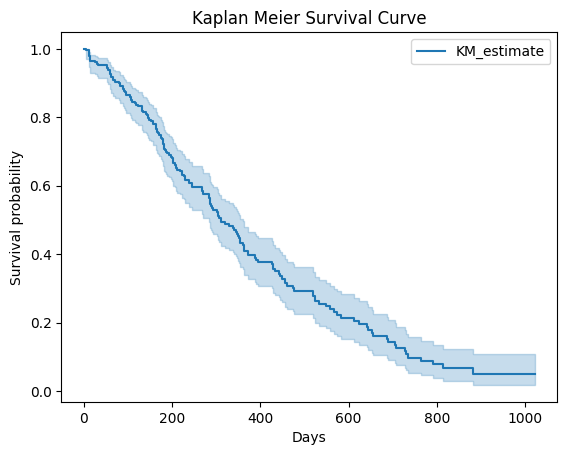

In [26]:
# Visualization - Survival curve
model.plot() # Plot the Kaplan-Meier survival curve
plt.title("Kaplan Meier Survival Curve")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.show()

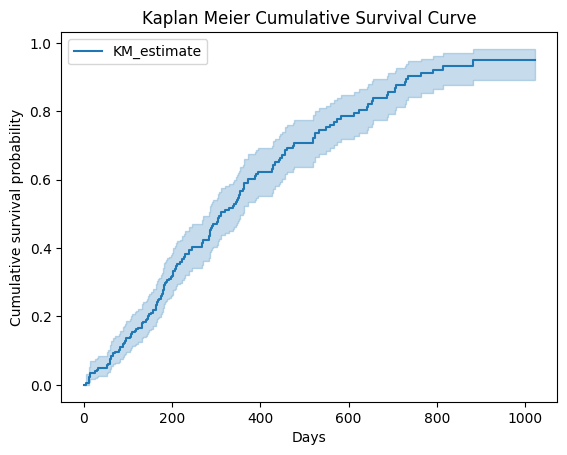

In [27]:
# Visualization - Cumulative survival curve
model.plot_cumulative_density() # Plot the cumulative survival curve (cumulative density)
plt.title("Kaplan Meier Cumulative Survival Curve")
plt.xlabel("Days")
plt.ylabel("Cumulative survival probability")
plt.show()

In [28]:
# Split between males and females
male = df.query("sex == 1")
female = df.query("sex == 2")
female.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
6,7.0,310,1,68,2,2.0,70.0,60.0,384.0,10.0
7,11.0,361,1,71,2,2.0,60.0,80.0,538.0,1.0
11,16.0,654,1,68,2,2.0,70.0,70.0,NaN,23.0
12,11.0,728,1,68,2,1.0,90.0,90.0,NaN,5.0
18,1.0,61,1,56,2,2.0,60.0,60.0,238.0,10.0


In [29]:
# KME Male
model_male = KaplanMeierFitter()
model_male.fit(durations =male.time, event_observed = male.status) # Fit the model using male data

#KME - Female
model_female = KaplanMeierFitter()
model_female.fit(durations =female.time, event_observed = female.status) # Fit the model using female data

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 90 total observations, 37 right-censored observations>

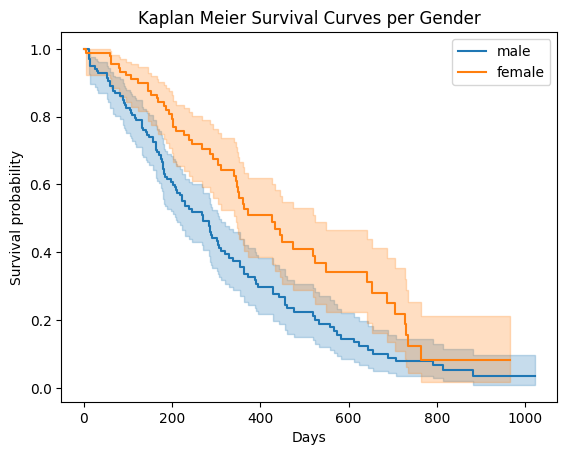

In [30]:
# Plot the survival curves
model_male.plot(label = "male") # Plot the Kaplan-Meier survival curve for males
model_female.plot(label = "female") # Plot the Kaplan-Meier survival curve for females
plt.title("Kaplan Meier Survival Curves per Gender")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.show()

# Female vs males Survival Analysis

**Null Hypothesis**: There is no difference between the male and female curves

**Alternative hypothesis**: There is a difference between the survival curves of males and females

In [14]:
def p_value_reader(p_value, alpha):
    if p_value <= alpha:
        return "Reject the null hypothesis"
    else:
        return "Fail to reject the null hypothesis"

In [31]:
# Log Rank Test
# to compare the survival distributions of two or more groups to determine if there are significant differences in survival times
results = logrank_test(durations_A = male.time, # Duration data for males
                      durations_B = female.time, # Duration data for females
                      event_observed_A = male.status, # Event data (status) for males
                      event_observed_B = female.status) # Event data (status) for females

In [32]:
# Interpret the p-value
p_value_reader(results.p_value, 0.05)

'Reject the null hypothesis'

# Prepare the df for CPH regression

In [34]:
df = df.dropna()
df.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
5,12.0,1022,0,74,1,1.0,50.0,80.0,513.0,0.0
6,7.0,310,1,68,2,2.0,70.0,60.0,384.0,10.0
7,11.0,361,1,71,2,2.0,60.0,80.0,538.0,1.0


In [35]:
df = df.drop(columns = ["inst"])

In [36]:
# Split the data into train and test
train_df, val_df = train_test_split(df,
                                    test_size = 0.2,
                                    random_state = 1502)

In [37]:
df.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
3,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
5,1022,0,74,1,1.0,50.0,80.0,513.0,0.0
6,310,1,68,2,2.0,70.0,60.0,384.0,10.0
7,361,1,71,2,2.0,60.0,80.0,538.0,1.0


In [38]:
# Cox Proportional Hazards (CPH) model
model = CoxPHFitter()
model.fit(train_df, duration_col = "time", event_col = 'status') # Fit the model to the training data with specified duration and event columns
model.print_summary()

<lifelines.CoxPHFitter: fitted with 133 total observations, 39 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 94
   partial log-likelihood = -363.82
         time fit was run = 2026-01-15 17:45:24 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.04                0.99                1.04
sex       -0.50      0.61      0.23           -0.95           -0.05                0.39                0.95
ph.ecog    0.63      1.88      0.27            0.11            1.15                1.12                3.17
ph.karno   0.02      1.02      0.01           -0.00            0.05                1.00                1.05
pat.karno -0.02      0.98      0.01           -0.03            0.00                0.97                1.00
meal.cal   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss   -0.02      0.98      0.01           -0.04           -0.00                0.96                1.00

           cmp to     z    p  -log2(p)
covariate                             
age          0.00  0.91 0.36      1.47
sex          0.00 -2.17 0.03      5.07
ph.ecog      0.00  2.38 0.02      5.85
ph.karno     0.00  1.90 0.06      4.13
pat.karno    0.00 -1.91 0.06      4.15
meal.cal     0.00  0.42 0.67      0.57
wt.loss      0.00 -2.07 0.04      4.71
---
Concordance = 0.65
Partial AIC = 741.64
log-likelihood ratio test = 20.74 on 7 df
-log2(p) of ll-ratio test = 7.90

In [39]:
import numpy as np

# Function to interpret the coefficients of CPH model
def interpret_coxph_lifelines(model):
    """
    Interprets the coefficients of a Cox Proportional Hazards model fitted using lifelines.
    Provides an interpretation for each coefficient and checks for statistical significance.

    Parameters:
    model : lifelines.CoxPHFitter
        The fitted Cox Proportional Hazards model.
    """

    # Get the coefficients and p-values
    summary = model.summary
    variables = summary.index
    params = summary['coef']
    pvalues = summary['p']

    for variable, coef, pvalue in zip(variables, params, pvalues):
        print('-' * 50)

        # Interpret coefficient
        print(f"For the variable '{variable}':")
        print(f"  - A unit increase in this variable alters the hazard by a factor of {np.exp(coef):.2f}.")

        # Check for statistical significance
        if pvalue < 0.05:
            print("  - This variable is statistically significant at the 0.05 level.")
        else:
            print("  - This variable is not statistically significant at the 0.05 level.")

    print('-' * 50)

In [40]:
# apply the function
interpret_coxph_lifelines(model)

--------------------------------------------------
For the variable 'age':
  - A unit increase in this variable alters the hazard by a factor of 1.01.
  - This variable is not statistically significant at the 0.05 level.
--------------------------------------------------
For the variable 'sex':
  - A unit increase in this variable alters the hazard by a factor of 0.61.
  - This variable is statistically significant at the 0.05 level.
--------------------------------------------------
For the variable 'ph.ecog':
  - A unit increase in this variable alters the hazard by a factor of 1.88.
  - This variable is statistically significant at the 0.05 level.
--------------------------------------------------
For the variable 'ph.karno':
  - A unit increase in this variable alters the hazard by a factor of 1.02.
  - This variable is not statistically significant at the 0.05 level.
--------------------------------------------------
For the variable 'pat.karno':
  - A unit increase in this variab

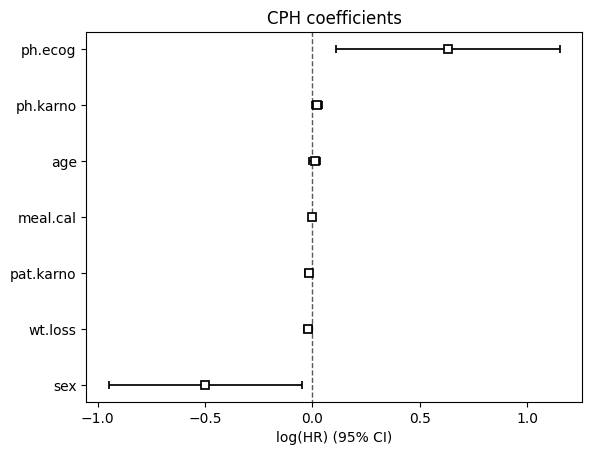

In [41]:
# Visualizing the coefficients
model.plot()
plt.title("CPH coefficients")
plt.show()

# Assess the Cox Models

In [42]:
# Isolate and prepare the validation data
val_time = val_df['time'] # time
val_status = val_df['status'] # status
val_X = val_df.drop(columns = ['time', 'status']) # features

In [43]:
# Calculate the predicted hazards
predicted_hazard = model.predict_partial_hazard(val_X)
predicted_hazard

25     1.013067
60     1.391381
164    1.140806
130    0.292247
72     1.758628
100    0.343233
6      1.450128
172    1.074406
67     0.648968
190    0.936466
90     1.009494
48     0.921296
74     0.879056
202    0.407511
110    0.927308
163    1.671894
176    1.672320
52     0.711439
171    0.456963
46     0.654294
69     0.623837
200    0.413309
70     0.828544
225    1.278691
77     1.005823
142    2.689124
64     2.170632
195    0.828734
89     2.656142
41     1.118089
14     0.602454
23     0.486573
185    0.296646
134    0.944206
dtype: float64

In [44]:
# Import the concordance_index function for evaluating model performance
from lifelines.utils import concordance_index

# Calculate the Concordance Index (C-index)
concordance_index_value = concordance_index(val_time,  # True event times
                                            -predicted_hazard,  # Predicted hazard ratios (negated for concordance calculation)
                                            val_status)  # True event statuses (0 for censored, 1 for event occurred)

print(f"The C-index is {concordance_index_value}")  # Print the C-index value, which measures the model's predictive accuracy

The C-index is 0.6437768240343348


# Predict specific instances

In [46]:
# Select the first row of the validation feature matrix as a single observation
instance = val_X.iloc[0]
# Predict the survival function for the given observation
predict_survival = model.predict_survival_function(instance)

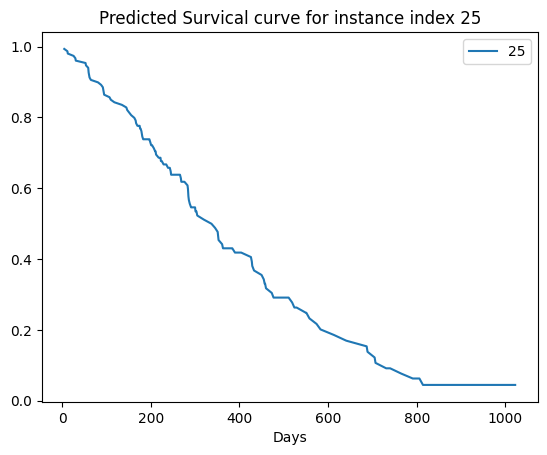

In [47]:
# Plot the prediction
predict_survival.plot()
plt.title("Predicted Survical curve for instance index 25")
plt.xlabel("Days")
plt.show()